# The Variance Gamma (VG) Model

There are different ways to implement the VG Model, some of which include:
1. Numerical solution of Variance Gamma Partial Integro-Differential Equation (PIDE)
2. Analytical solutions of Variance Gamma equation
3. Monte Carlo simulation
4. Fast Fourier Transform

Numerical solution of Variance Gamma PIDE would be elaboratory implemented and a touch on Monte Carlo to compare results.

## Highlights
   - [The VG PIDE](#sec1)
   - [Numerical solution of the PIDE](#sec2)
   - [Comparison with Monte Carlo, closed formula and Fourier inversion](#sec3)
   - [Comparison with the Black Scholes PDE](#sec4)  


The Variance Gamma Partial Integro-Differential Equation

<a id='sec1'></a>
## The VG PIDE   
The VG PIDE can be solved by the commonly used numerical solution, Finite difference method. An approche introduced by _CONT & VOLTCHKOVA_ <sup>[1]<sup>. The VG Model identical to the Merton PIDE, except for the truncation in the integral.

The approximated VG PIDE has the following form:    

$$
  \frac{\partial V(t,x)}{\partial t} +
 \bigl( r-\frac{1}{2}\sigma_{\epsilon}^2 - w_{\epsilon} \bigr) \frac{\partial V(t,x)}{\partial x} 
 + \frac{1}{2}\sigma_{\epsilon}^2 \frac{\partial^2 V(t,x)}{\partial x^2}
 + \int_{|z| \geq \epsilon} V(t,x+z) \nu(dz) = (\lambda_{\epsilon} + r) V(t,x).
$$

with parameters   

$$
  \sigma_{\epsilon}^2 :=  \int_{|z| < \epsilon} z^2 \nu(dz), \quad \quad w_{\epsilon} := \int_{|z| \geq \epsilon} (e^z-1) \nu(dz), \quad \quad
 \lambda_{\epsilon} :=  \int_{|z| \geq \epsilon} \nu(dz) .
$$

and Lévy measure:   

$$
 \nu(dz) = \frac{e^{\frac{\theta z}{\sigma^2}}}{\kappa|z|} \exp 
 \left( - \frac{\sqrt{\frac{2}{\kappa} + \frac{\theta^2}{\sigma^2}}}{\sigma} |z|\right) dz,
$$

$\theta$, $\sigma$ and $\kappa$ as the three parameters of the model.



The activity of the VG process is infinite, i.e. $\lambda = \int_{-\infty}^{\infty} \nu(z) = \infty$. Since the interval $-\epsilon < z < \epsilon$ is removed from the region of integration, all the parameters defined above are finite! 

<a id='sec2'></a>
## Numerical solution of the PIDE

In [166]:
import numpy as np
import scipy as scp
import scipy.stats as ss
from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as web
from datetime import datetime


In [167]:
# Fetch Brent crude oil data
series_id = 'DCOILBRENTEU'
start_date = datetime(1994, 8, 31)
end_date = datetime(2024, 7, 1)
data = web.DataReader(series_id, 'fred', start_date, end_date)

# Calculate returns and volatility
returns = np.log(data['DCOILBRENTEU'] / data['DCOILBRENTEU'].shift(1)).dropna()
annual_volatility = returns.std() * np.sqrt(252)


In [168]:
# Set parameters
r = 0.05  # risk-free rate (you may want to adjust this)
theta = -0.1
sigma = annual_volatility 
kappa = 0.3
S0 = data['DCOILBRENTEU'].iloc[-1]  # Current price
X0 = np.log(S0)
K = S0  # At-the-money option
Texpir = 1  # 252 trading days

In [169]:
# Variance Gamma model parameters
W = -np.log(1 - theta * kappa - kappa / 2 * sigma**2) / kappa
dev_X = np.sqrt(sigma**2 + theta**2 * kappa)

In [170]:
# Discretization parameters
Nspace = 1000
Ntime = 12  # 12 steps per year 1 for each month
S_max = 3 * float(K)
S_min = float(K) / 3
x_max = np.log(S_max)
x_min = np.log(S_min)

dx = (x_max - x_min) / (Nspace - 1)
extraP = int(np.floor(3 * dev_X / dx))
x = np.linspace(x_min - extraP * dx, x_max + extraP * dx, Nspace + 2 * extraP)
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)

In [171]:
# Lévy measure and related functions
A = theta / (sigma**2)
B = np.sqrt(theta**2 + 2 * sigma**2 / kappa) / sigma**2
levy_m = lambda y: np.exp(A * y - B * np.abs(y)) / (kappa * np.abs(y))

eps = 1.5 * dx
lam = quad(levy_m, -(extraP + 1.5) * dx, -eps)[0] + quad(levy_m, eps, (extraP + 1.5) * dx)[0]

int_w = lambda y: (np.exp(y) - 1) * levy_m(y)
int_s = lambda y: np.abs(y) * np.exp(A * y - B * np.abs(y)) / kappa

w = quad(int_w, -(extraP + 1.5) * dx, -eps)[0] + quad(int_w, eps, (extraP + 1.5) * dx)[0]
sig2 = quad(int_s, -eps, eps)[0]
sigJ = quad(int_s, -(extraP + 1.5) * dx, -eps)[0] + quad(int_s, eps, (extraP + 1.5) * dx)[0]

In [172]:
# PIDE discretization
dxx = dx * dx
a = (dt / 2) * ((r - w - 0.5 * sig2) / dx - sig2 / dxx)
b = 1 + dt * (sig2 / dxx + r + lam)
c = -(dt / 2) * ((r - w - 0.5 * sig2) / dx + sig2 / dxx)
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()
DD = splu(D)

nu = np.zeros(2 * extraP + 3)
x_med = extraP + 1
x_nu = np.linspace(-(extraP + 1 + 0.5) * dx, (extraP + 1 + 0.5) * dx, 2 * (extraP + 2))

for i in range(len(nu)):
    if (i == x_med) or (i == x_med - 1) or (i == x_med + 1):
        continue
    nu[i] = quad(levy_m, x_nu[i], x_nu[i + 1])[0]


In [173]:
# Initialize grid and set boundary conditions
Payoff = np.maximum(np.exp(x) - K, 0)
V = np.zeros((Nspace + 2 * extraP, Ntime))
V[:, -1] = Payoff
V[-extraP - 1:, :] = np.exp(x[-extraP - 1:]).reshape(extraP + 1, 1) * np.ones((extraP + 1, Ntime)) - K * np.exp(-r * T[::-1]) * np.ones((extraP + 1, Ntime))
V[: extraP + 1, :] = 0

In [174]:
# Backward iteration
for i in range(Ntime - 2, -1, -1):
    offset = np.zeros(Nspace - 2)
    offset[0] = a * V[extraP, i]
    offset[-1] = c * V[-1 - extraP, i]
    V_jump = V[extraP + 1 : -extraP - 1, i + 1] + dt * np.convolve(V[:, i + 1], nu[::-1], mode="valid")
    V[extraP + 1 : -extraP - 1, i] = DD.solve(V_jump - offset)

eps =  0.0032991360020063346


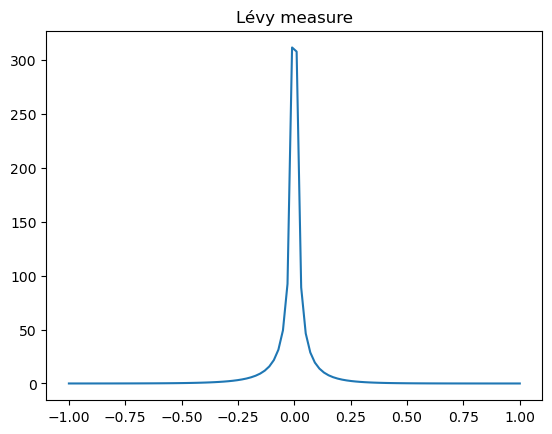

The intensity lam=22.052584 is very small because the mass is concentrated inside [-eps,eps].

Theoretical w:  -0.017524692329191207
Approximated w, w_eps =  -0.0174560523403664
Integral of int_w inside the truncation [-eps,eps]:  -3.8136464299756007e-06


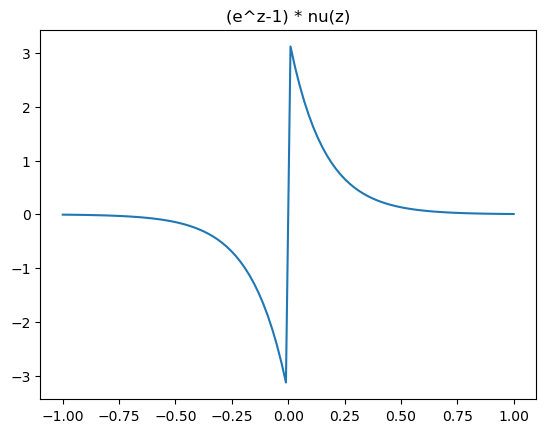

The VG variance 0.167081 is equal to the sum of the Var of the decomposed processes 0.167858.
Under this discretization the diffusion variance 0.000036 is the major component. 


In [175]:
print("eps = ", eps)
plt.plot(np.linspace(-1, 1, 100), levy_m(np.linspace(-1, 1, 100)))
plt.title("Lévy measure")
plt.show()
print(
    "The intensity lam={:.6f} \
is very small because the mass is concentrated inside [-eps,eps].".format(
        lam
    )
)
print("")

print("Theoretical w: ", W)
print("Approximated w, w_eps = ", w)
print("Integral of int_w inside the truncation [-eps,eps]: ", quad(int_w, -eps, 1e-10)[0] + quad(int_w, 1e-10, eps)[0])
plt.plot(np.linspace(-1, 1, 100), int_w(np.linspace(-1, 1, 100)))
plt.title("(e^z-1) * nu(z)")
plt.show()

print(
    "The VG variance {0:.6f} is equal to the sum of the Var of the decomposed \
processes {1:.6f}.".format(
        sigJ + sig2, dev_X**2
    )
)
print("Under this discretization the diffusion variance {:.6f} is the major component. ".format(sig2))

In [209]:
# Interpolate to get option price at S0
oPrice = np.interp(X0, x, V[:, 0])

print(f"Brent Crude Oil Price: ${S0:.2f}")
print(f" Option Price at S0: ${oPrice:.2f}")


Brent Crude Oil Price: $86.57
 Option Price at S0: $8.02


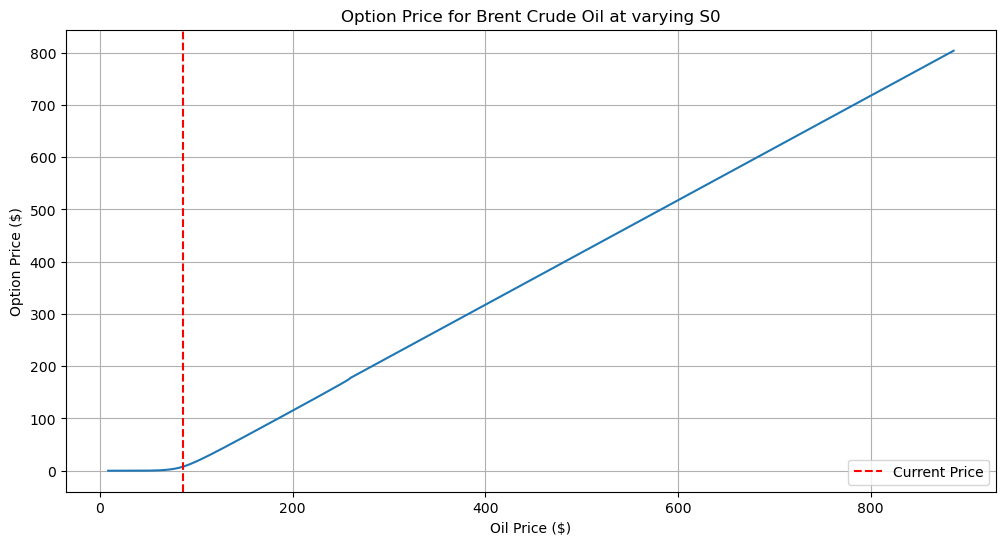

In [211]:
# Plot the option price curve
plt.figure(figsize=(12, 6))
plt.plot(np.exp(x), V[:, 0])
plt.title("Option Price for Brent Crude Oil at varying S0")
plt.xlabel("Oil Price ($)")
plt.ylabel("Option Price ($)")
plt.axvline(S0, color='r', linestyle='--', label='Current Price')
plt.legend()
plt.grid(True)
plt.show()

In [178]:
%load_ext cython


The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [179]:
%%cython
import numpy as np
from scipy.linalg import norm
cimport numpy as np
cimport cython

cdef np.float64_t distance2(np.float64_t[:] a, np.float64_t[:] b, unsigned int N):
    cdef np.float64_t dist = 0
    cdef unsigned int i    
    for i in range(N):
        dist += (a[i] - b[i]) * (a[i] - b[i])
    return dist


@cython.boundscheck(False)
@cython.wraparound(False)
def SOR(np.float64_t aa, 
        np.float64_t bb, np.float64_t cc, 
        np.float64_t[:] b, 
        np.float64_t w=1, np.float64_t eps=1e-10, unsigned int N_max = 500):
    
    cdef unsigned int N = b.size
    
    cdef np.float64_t[:] x0 = np.ones(N, dtype=np.float64)          # initial guess
    cdef np.float64_t[:] x_new = np.ones(N, dtype=np.float64)      # new solution

    
    cdef unsigned int i, k
    cdef np.float64_t S
    
    for k in range(1,N_max+1):
        for i in range(N):
            if (i==0):
                S = cc * x_new[1]
            elif (i==N-1):
                S = aa * x_new[N-2]
            else:
                S = aa * x_new[i-1] + cc * x_new[i+1]
            x_new[i] = (1-w)*x_new[i] + (w/bb) * (b[i] - S)  
        if distance2(x_new, x0, N) < eps*eps:
            return x_new
        x0[:] = x_new
        if k==N_max:
            print("Fail to converge in {} iterations".format(k))
            return x_new


@cython.boundscheck(False)
@cython.wraparound(False)
def PSOR(np.float64_t aa, 
        np.float64_t bb, np.float64_t cc, 
        np.float64_t[:] B,  np.float64_t[:] C, 
        np.float64_t w=1, np.float64_t eps=1e-10, unsigned int N_max = 500):
    
    cdef unsigned int N = B.size
    
    cdef np.float64_t[:] x0 = np.ones(N, dtype=np.float64)          # initial guess
    cdef np.float64_t[:] x_new = np.ones(N, dtype=np.float64)       # new solution

    cdef unsigned int i, k
    cdef np.float64_t S
    
    for k in range(1,N_max+1):
        for i in range(N):
            if (i==0):
                S = cc * x_new[1]
            elif (i==N-1):
                S = aa * x_new[N-2]
            else:
                S = aa * x_new[i-1] + cc * x_new[i+1]
            x_new[i] = (1-w)*x_new[i] + (w/bb) * (B[i] - S)  
            x_new[i] = x_new[i] if (x_new[i] > C[i]) else C[i]
            
        if distance2(x_new, x0, N) < eps*eps:
            print("Convergence after {} iterations".format(k))
            return x_new
        x0[:] = x_new
        if k==N_max:
            print("Fail to converge in {} iterations".format(k))
            return x_new

In [180]:
from PRICER.Parameters import Param_Options
from PRICER.Processes import Diffusion_process, VG_process
from PRICER.BS_pricer import BS_pricer
from PRICER.VG_pricer import VG_pricer

In [181]:
# Creates the object with the parameters of the option
opt_param = Param_Options(S0=data['DCOILBRENTEU'].iloc[-1], K=S0, T=1, exercise="European", payoff="call")
# Creates the object with the parameters of the process
VG_param = VG_process(r=0.05, sigma=annual_volatility, theta=-0.1, kappa=0.3)
# Creates the VG pricer
VG = VG_pricer(opt_param, VG_param)

PIDE price

In [182]:
VG.PIDE_price((30000, 30000), Time=True)

(15.289076375748746, 376.7614469528198)

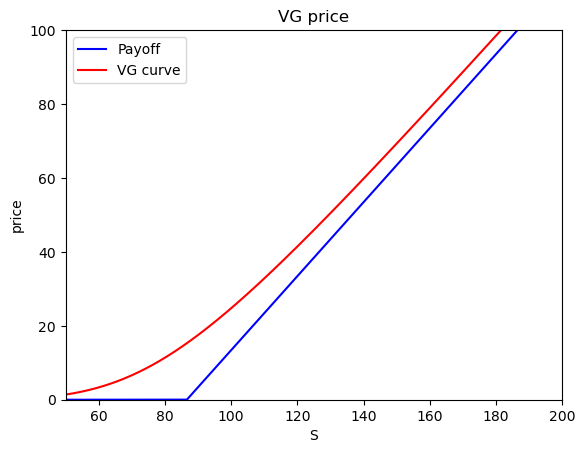

In [183]:
VG.plot([50, 200, 0, 100])

**Closed formula**:

The semi-closed formula the closed formula by _CONT & VOLTCHKOVA_<sup> [1]<sup>

In [184]:
VG.closed_formula()

15.791790730838756

In [185]:
VG.Fourier_inversion()

15.30124506694333

**Monte Carlo**:

(the output includes the price, the standard error and the execution time)

In [208]:
VG.MC(20000000, Err=True, Time=True)

(array([15.29770172]), array([0.00633385]), 3.214808225631714)

In [ ]:
VG.PIDE_price, VG.closed_formula(), VG.Fourier_inversion(), VG.MC(20000000, Err=True, Time=True)

The function `MC` uses the following code.

In [187]:
N = 10000000
rho = 1 / kappa
T = 1
w = -np.log(1 - theta * kappa - kappa / 2 * sigma**2) / kappa  # martingale correction
G = ss.gamma(rho * T).rvs(N) / rho  # gamma random vector
Norm = ss.norm.rvs(0, 1, N)  # standard normal vector
VG_RV = theta * G + sigma * np.sqrt(G) * Norm  # VG vector obtained by subordination
S_T = S0 * np.exp((r - w) * T + VG_RV)  # exponential dynamics
call = np.exp(-r * T) * scp.mean(np.maximum(S_T - K, 0))
put = np.exp(-r * T) * scp.mean(np.maximum(K - S_T, 0))
print("Monte Carlo, call: {}, put: {}".format(call, put))

Monte Carlo, call: 15.306759184297329, put: 11.0807244925279


/var/folders/dz/_kvh33pj1bv3mz3jxzf_x5lr0000gn/T/ipykernel_65956/2615911637.py:9: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  call = np.exp(-r * T) * scp.mean(np.maximum(S_T - K, 0))
/var/folders/dz/_kvh33pj1bv3mz3jxzf_x5lr0000gn/T/ipykernel_65956/2615911637.py:10: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  put = np.exp(-r * T) * scp.mean(np.maximum(K - S_T, 0))


### Put option

In [188]:
opt_param_p = Param_Options(S0=data['DCOILBRENTEU'].iloc[-1], K=S0, T=1, exercise="European", payoff="put")
VG_p = VG_pricer(opt_param_p, VG_param)

In [189]:
print("PIDE price: ", VG_p.PIDE_price((12000, 9000)))
print("Fourier price: ", VG_p.Fourier_inversion())
# the closed formula for the put is calculated by PUT/CALL parity
print("Closed formula price: ", VG_p.closed_formula())
print("MC price: ", VG_p.MC(10000000))

PIDE price:  11.067976673465505
Fourier price:  11.079176345970147
Closed formula price:  11.569722009865572
MC price:  [11.08005356]


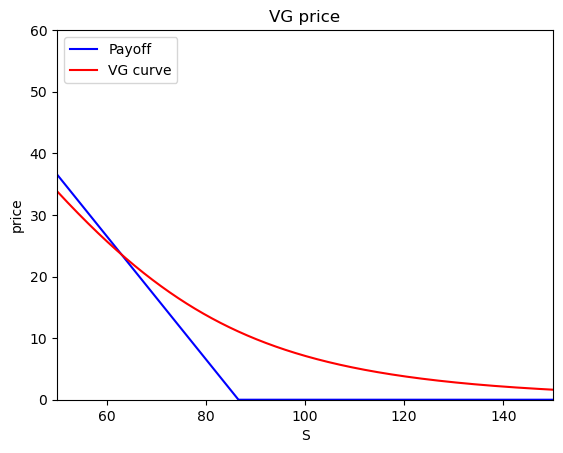

In [190]:
VG_p.plot([50, 150, 0, 60])

### Remark:

There are some discrepancies between the outputs of the four numerical methods.    

- The Monte Carlo and Fourier prices are the most reliable

- The convergence of the PIDE, when considering the Brownian approximation, is quite slow.
  - For the put option we didn't need a huge grid in order to obtain the right price.
  - But for the call option I had to use a huge grid (30000x30000). I expect to achieve a better convergence level for higher grid resolution, in particular when increasing the number of time steps.
  - Increasing the computational domain $[A_1,A_2]$ may also help.

- The semi-closed formula used in VG_pricer is taken from [1]. In my opinion, this formula is not very accurate.   



The results from the four numerical techniques differ in a few ways.    

- The most dependable prices are the Fourier and Monte Carlo estimates.

- The PIDE's convergence is quite sluggish when the Brownian approximation is taken into account.
  - We didn't require a large grid is not required  to get the best price on the put option but a  a very large grid (30000x30000) for the call option is used. Higher grid resolution should allow 

- [1] is the source of the semi-closed formula utilized in VG_pricer. This formula is not very accurate, in my opinion.     
  



<a id='sec4'></a>
## Comparison with the Black Scholes Model

Now let us compare the VG curve with the Black Scholes curve, for a European call option.    
The volatility of the BS model is chosen equal to the standard deviation of the VG process. 

In this case I'm going to select some parameters with the purpose to have high values of skewness and kurtosis for the VG distribution.    
In the VG process, the parameter $\theta$ is associated to the skewness, and the parameter $\kappa$ is associated to the kurtosis.

Looking at the plot we can notice the different shape of the two curves.

In [191]:
# Creates the object with the parameters of the option
opt_param = Param_Options(S0=data['DCOILBRENTEU'].iloc[-1], K=S0, T=1, exercise="European", payoff="call")
# Creates the object with the parameters of the process
VG_param2 = VG_process(r=0.05, sigma=annual_volatility, theta=-0.2, kappa=2.5)
VG_param3 = VG_process(r=0.05, sigma=annual_volatility, theta=+0.2, kappa=2.5)
diff_param = Diffusion_process(r=0.05, sig=np.sqrt(VG_param2.var))

print("standard deviation: ", np.sqrt(VG_param2.var))
print("skewness: ", VG_param2.skew)
print("kurtosis: ", VG_param2.kurt)
print("Changing the sign of theta, the skewness becomes: ", VG_param3.skew)

# Creates the object of the pricer
BS = BS_pricer(opt_param, diff_param)
VG2 = VG_pricer(opt_param, VG_param2)
VG3 = VG_pricer(opt_param, VG_param3)

standard deviation:  0.5146438761065874
skewness:  -2.5478197357729413
kurtosis:  12.09426662628385
Changing the sign of theta, the skewness becomes:  2.5478197357729413


In [192]:
BS.PDE_price((7000, 4000), Time=True)

(19.340574568270092, 1.6807711124420166)

In [193]:
VG2.PIDE_price((14000, 10000), Time=True)  # negative skewness

(13.681099121209357, 46.00735807418823)

In [194]:
VG3.PIDE_price((14000, 10000), Time=True)  # positive skewness

(20.995488687630953, 49.28463792800903)

In [195]:
def plot_comparison(BS, VG2, VG3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(BS.S_vec, BS.price_vec, color="red", label="BS curve")
    ax1.plot(VG2.S_vec, VG2.price_vec, color="green", label="VG curve")
    ax1.plot(VG2.S_vec, VG2.payoff_f(VG2.S_vec), color="black", label="Payoff")
    ax1.set_xlim(50, 150)
    ax1.set_ylim(0, 50)
    ax1.set_xlabel("S")
    ax1.set_ylabel("price")
    ax1.set_title("VG vs BS - same variance - negative skewness")
    ax1.legend()

    ax2.plot(BS.S_vec, BS.price_vec, color="red", label="BS curve")
    ax2.plot(VG3.S_vec, VG3.price_vec, color="green", label="VG curve")
    ax2.plot(VG3.S_vec, VG3.payoff_f(VG3.S_vec), color="black", label="Payoff")
    ax2.set_xlim(50, 170)
    ax2.set_ylim(0, 80)
    ax2.set_xlabel("S")
    ax2.set_ylabel("price")
    ax2.set_title("VG vs BS - same variance - positive skewness")
    ax2.legend()

    plt.show()

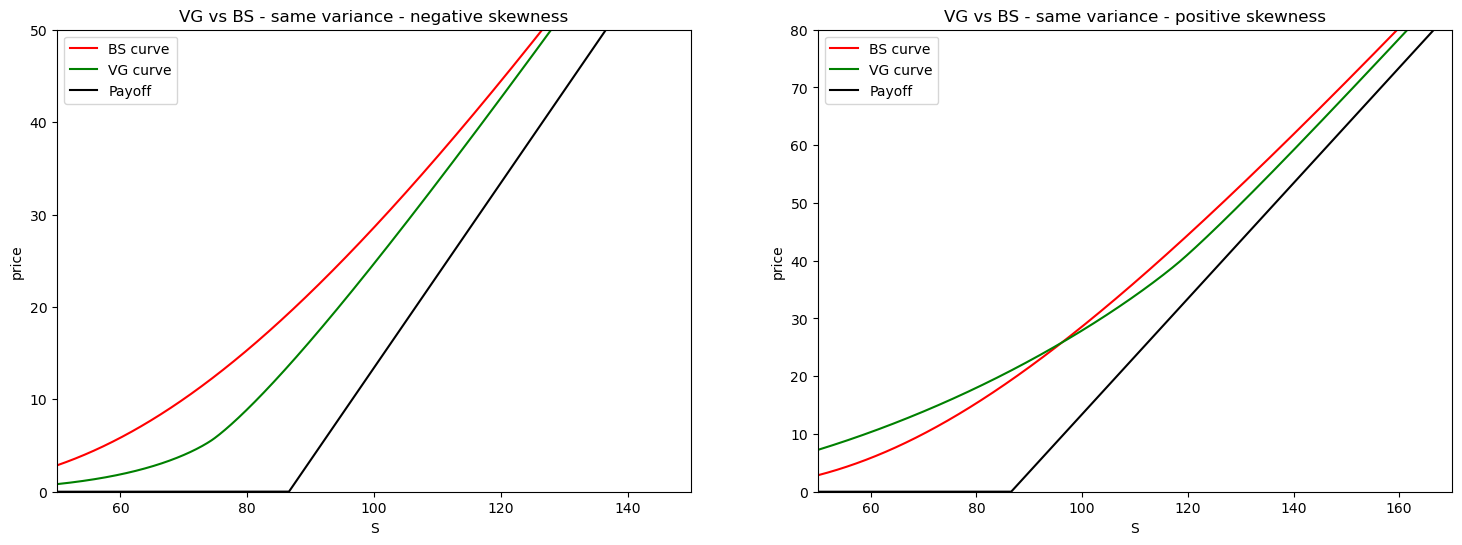

In [196]:
plot_comparison(BS, VG2, VG3)